# Implementation and Analysis of TSP Algorithms

#### Dependencies

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import networkx as nx
from collections import defaultdict
import heapq
import copy 
import random
import tspsolve
import itertools
import random
import sys

#### Graph builders

In [ ]:
def complete_graph(n):
    G = nx.complete_graph(n, create_using = nx.Graph)
    for u, v, d in G.edges(data=True):
        d['weight'] = random.randrange(1, 10)
    return G

def complete_graph_matrix(G, n):
    dists = [[0] * n for i in range(n)]
    for u, v, d in G.edges(data=True):
            dists[u][v] = dists[v][u] = d['weight']
    return dists
    
def Pretty_Print(G):
    for row in G_:
        print(''.join([str(n).rjust(3, ' ') for n in row]))

  0  2  1  8  4
  2  0  6  8  5
  1  6  0  2  3
  8  8  2  0  1
  4  5  3  1  0




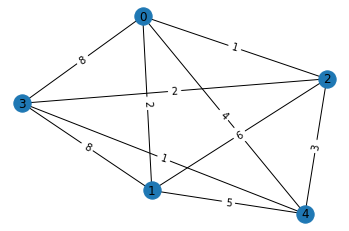

In [2]:
G = complete_graph(5)
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw(G, pos, with_labels=True)
G_ = complete_graph_matrix(G, len(G))
Pretty_Print(G_)
print('\n')

## Exact Algorithm
#### Held-Karp Algorithm

In [3]:
def held_karp(dists):
    """
    Implementation of Held-Karp, an algorithm that solves the Traveling
    Salesman Problem using dynamic programming with memoization.
    Parameters:
        dists: distance matrix
    Returns:
        A tuple, (cost, path).
    """
    n = len(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))


In [9]:
start = time.time()
print("Shortest path hamiltonian cycle: ", held_karp(G_))
print(time.time() - start)

Shortest path hamiltonian cycle:  (11, [0, 2, 3, 4, 1])
0.0


In [ ]:
n = 20
repeat = 1
runtimes = []
G = complete_graph(n)
for i in range(n):
    dists = complete_graph_matrix(G, n)
    start = time.time()
    for j in range(repeat):
        held_karp(dists)    
    runtimes.append((time.time() - start)/repeat)
    print((time.time() - start)/repeat)
plt.plot([i for i in range(n)], runtimes)
plt.show()

## Approximation Algorithms
#### Pairwise Exchange Algorithm

In [7]:
# Calculate the change in the total weight of path
def cost_change(cost_mat, n1, n2, n3, n4):
    return cost_mat[n1][n3] + cost_mat[n2][n4] - cost_mat[n1][n2] - cost_mat[n3][n4]


# Takes in an adjacency matrix and arbitrary route

def pairwise_ex(route, cost_mat):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                # Continue if the edges have shared nodes
                if j - i == 1: continue
                if cost_change(cost_mat, best[i - 1]-1, best[i]-1, best[j - 1]-1, best[j]-1) < 0:
                    # Swap the edges if the path improves
                    best[i:j] = best[j - 1:i - 1:-1]
                    improved = True
        route = best
    return best


In [8]:
start = time.time()
print("Shortest path hamiltonian cycle: ", pairwise_ex(list(G.nodes()), G_))
print(time.time() - start)

Shortest path hamiltonian cycle:  [0, 2, 1, 3, 4]


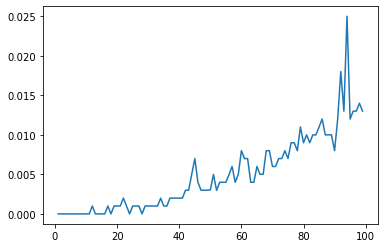

In [10]:
runtimes = []
for i in range(1, 100):
    G = complete_graph(i)
    G_ = complete_graph_matrix(G, len(G))
    start = time.time()
    pairwise_ex(list(G.nodes()), G_)
    runtimes.append(time.time() - start)

plt.plot([i for i in range(1, 100)], runtimes)
plt.show()

#### Christofides-Serdyukov Algorithm

In [11]:
def odd_vertices(T: nx.Graph):
    odd_set = set()
    for v in T:
        if nx.degree(T, v)%2 == 1:
            odd_set.add(v)
    return odd_set

def min_match(G):
    matching = nx.Graph()
    for v in G:
        #print(v)
        mydict = {}
        for u in G[v]:
            if u not in matching and v not in matching:
                mydict[u] = G[v][u]['weight']
            
        if v != None and mydict:
            x = min(mydict, key = mydict.get)
            matching.add_node(v)
            matching.add_node(x)
            matching.add_weighted_edges_from([(v, x, G[v][u]['weight'])])
    return matching 



def chirstoalgo(G, v):
    min_tree = nx.minimum_spanning_tree(G, v)
    x = odd_vertices(min_tree)
    sub = G.subgraph(x)
    matching = min_match(sub)

    multi = nx.MultiGraph()
    multi.add_weighted_edges_from(min_tree.edges(data='weight'))
    multi.add_weighted_edges_from(matching.edges(data='weight'))
    multi.add_nodes_from(min_tree.nodes())

    e_circ = [u for u,x in nx.eulerian_circuit(multi, source=v)] 
    tsp_path = list(dict.fromkeys(e_circ))
    return tsp_path

In [15]:
start = time.time()
print("Shortest path hamiltonian cycle: ", chirstoalgo(G, 0))
print(time.time() - start)

Shortest path hamiltonian cycle:  [0, 97, 94, 95, 92, 98, 87, 89, 84, 96, 82, 90, 81, 86, 79, 91, 76, 93, 74, 77, 72, 78, 70, 80, 69, 88, 68, 71, 66, 73, 63, 75, 62, 65, 61, 83, 57, 60, 56, 55, 51, 67, 49, 58, 47, 64, 46, 50, 45, 52, 41, 53, 40, 54, 38, 48, 35, 59, 34, 85, 33, 36, 32, 44, 29, 37, 27, 39, 26, 43, 25, 30, 24, 22, 21, 42, 20, 31, 18, 19, 17, 23, 16, 13, 11, 15, 10, 12, 9, 28, 7, 14, 5, 6, 3, 8, 2, 4, 1]
0.08899784088134766


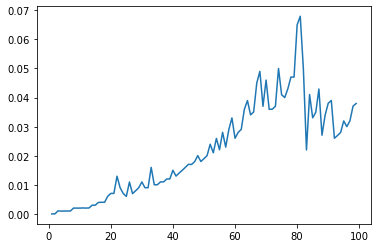

In [14]:
runtimes = []
for i in range(1, 100):
    G = complete_graph(i)
    G_ = complete_graph_matrix(G, len(G))
    start = time.time()
    chirstoalgo(G, 0)
    runtimes.append(time.time() - start)

plt.plot([i for i in range(1, 100)], runtimes)
plt.show()

#### Nearest Neighbors Algorithm

In [18]:
def n_neighbors(A, start):
    """Nearest neighbor algorithm.
    A is an NxN array indicating distance between N locations
    start is the index of the starting location
    Returns the path and cost of the found solution
    """
    path = [start]
    cost = 0
    N = len(A)
    mask = np.ones(N, dtype=bool)  # boolean values indicating which 
                                   # locations have not been visited
    mask[start] = False

    for i in range(N-1):
        last = path[-1]
        next_ind = np.argmin(A[last][mask]) # find minimum of remaining locations
        next_loc = np.arange(N)[mask][next_ind] # convert to original location
        path.append(next_loc)
        mask[next_loc] = False
        cost += A[last, next_loc]

    return path, cost


In [ ]:
print("Shortest path hamiltonian cycle: ", chirstoalgo(G_, 0))

In [ ]:
runtimes = []
for i in range(1, 100):
    G = complete_graph(i)
    G_ = complete_graph_matrix(G, len(G))
    start = time.time()
    n_neighbors(G, 0)
    runtimes.append(time.time() - start)

plt.plot([i for i in range(1, 100)], runtimes)
plt.show()

## Empirical Analysis

def EA2(n, repeat, algo):
    runtimes = []
#     if (algo == "hk"):
#             return [n**2*2**n for i in range(1,n)]
    for i in range(1,n):
        
        
        G1 = complete_graph(i)
        G2 = complete_graph_matrix(G1, i)
#         for row in G2:
#             print(''.join([str(n).rjust(3, ' ') for n in row]))
        
        if (algo == "cs"):
            start = time.time()
            for j in range(repeat):
                chirstoalgo(G1, 0)    
            runtimes.append((time.time() - start)/repeat)
            
        elif (algo == "hk" and i < 15):
            start = time.time()
            for j in range(repeat):
                held_karp(G2)    
            runtimes.append((time.time() - start)/repeat) 
            
        
        elif (algo == "nn"):
            start = time.time()
            for j in range(repeat):
                tspsolve.nearest_neighbor(list(G1.nodes()), G2)
            runtimes.append((time.time() - start)/repeat)
            
        
        elif (algo == "pe"):
            start = time.time()
            for j in range(repeat):
                pairwise_ex(list(G1.nodes()), G2)
            runtimes.append((time.time() - start)/repeat)
            
    return runtimes 
        
def Empirical_Analysis(n, repeat):
    n_values = np.array([i for i in range(1, n)])
    hk_runtimes = []
#     nn_runtimes = EA2(n, repeat, "nn")
    cs_runtimes = EA2(n, repeat, "cs")
    pe_runtimes = EA2(n, repeat, "pe")
        
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(n_values, [(n**2)*(2**n) for i in range(1,n)])
    axs[0, 0].set_title("Held-Karp")     
    axs[1, 0].plot(n_values, nn_runtimes)
    axs[1, 0].set_title("Nearest Neighbor")
    axs[0, 1].plot(n_values, [(n**2)for i in range(1,n)])
    axs[0, 1].set_title("Christofides")
    axs[1, 1].plot(n_values, pe_runtimes)
    axs[1, 1].set_title("Pairwise Exchange")
    
    fig.tight_layout()
    plt.show()
    

NameError: name 'nn_runtimes' is not defined

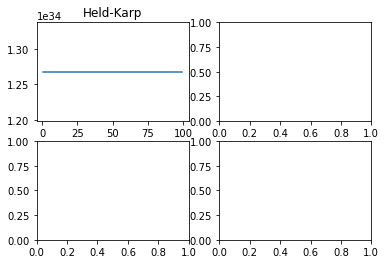

In [22]:
Empirical_Analysis(100, 3)